## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [29]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [30]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
   # fill this
   root="./data",
   train=True,
   download=True,
   transform=transform

)
test_dataset = torchvision.datasets.MNIST(
    # fill this
    root="./data",
    train=False,
    download=True,
    transform=transform
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

✅ MNIST loaded: 60000 train, 10000 test images


In [31]:
# TODO: Define your task structure
task_definitions = {
    'A':[0,1],
    'B':[2,3],
    'C':[4,5],
    'D':[6,7],
    'E':[8,9]
}

def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
    indices=[i for i, label in enumerate(dataset.targets) if label in task_classes]
    random.shuffle(indices)
    train_indices=indices[:n_train]
    support_indices=indices[n_train:n_train+n_support]
    query_indices=indices[n_train+n_support:n_train+n_support+n_query]
    train_data = Subset(dataset, train_indices)
    support_data = Subset(dataset, support_indices)
    query_data = Subset(dataset, query_indices)
    return train_data, support_data, query_data
    print("Function defined")
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [32]:
train_A, support_A, query_A = create_task_datasets(
    train_dataset,
    task_definitions['A'],
    n_train=2000,
    n_support = 10,
    n_query = 200
    )
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 2000, Support: 10, Query: 200


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [33]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("Model Architecture defined.")
def train_model(model, train_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if model.classifier[-1].out_features == 2:
                labels = labels % 2
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(train_loader))
    return loss_history

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            if model.classifier[-1].out_features == 2:
                labels = labels % 2

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

✅ Model Architecture defined.


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [34]:
#Method 1 - Fully Trained Binary Classifier on Task A
train_loader_A = DataLoader(train_A, batch_size=64, shuffle=True)
query_loader_A = DataLoader(query_A, batch_size=64, shuffle=False)
model_A_full = SimpleCNN(num_classes=2).to(device)
print("Training Method 1 (Full Train Task A)...")
loss_A = train_model(model_A_full, train_loader_A, epochs=5, lr=0.001)
acc_A = evaluate_model(model_A_full, query_loader_A)
print(f"Method 1 Accuracy on Task A Query Set: {acc_A:.2f}%")

Training Method 1 (Full Train Task A)...
Method 1 Accuracy on Task A Query Set: 100.00%


In [37]:
#Method 2 - Fine Tuning all 3 methods
support_loader_A = DataLoader(support_A, batch_size=5, shuffle=True)
model_random_ft = SimpleCNN(num_classes=2).to(device)
loss_random_ft = train_model(model_random_ft, support_loader_A, epochs=20, lr=0.01)

acc_random_ft = evaluate_model(model_random_ft, query_loader_A)
print(f"Method 2.1 (Random Init + FT Task A) Accuracy: {acc_random_ft:.2f}%")
train_B, support_B, query_B = create_task_datasets(train_dataset, task_definitions['B'])
support_loader_B = DataLoader(support_B, batch_size=5, shuffle=True)
query_loader_B = DataLoader(query_B, batch_size=64, shuffle=False)
model_transfer = SimpleCNN(num_classes=2).to(device)
model_transfer.load_state_dict(model_A_full.state_dict())
model_transfer.classifier[-1] = nn.Linear(128, 2).to(device)
loss_transfer = train_model(model_transfer, support_loader_B, epochs=20, lr=0.01)

acc_transfer = evaluate_model(model_transfer, query_loader_B)
print(f"Method 2.2 (Transfer A->B + FT) Accuracy: {acc_transfer:.2f}%")
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
model_general = SimpleCNN(num_classes=10).to(device)

print("Training Generalist Model (All 10 digits)... this takes a moment")
train_model(model_general, full_train_loader, epochs=3, lr=0.001)
model_pretrain_ft = SimpleCNN(num_classes=2).to(device)
pretrained_dict = model_general.state_dict()
model_dict = model_pretrain_ft.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
model_pretrain_ft.load_state_dict(model_dict)
loss_pretrain_ft = train_model(model_pretrain_ft, support_loader_A, epochs=20, lr=0.001)

acc_pretrain_ft = evaluate_model(model_pretrain_ft, query_loader_A)
print(f"Method 2.3 (Pretrain All -> FT Task A) Accuracy: {acc_pretrain_ft:.2f}%")

Method 2.1 (Random Init + FT Task A) Accuracy: 95.00%
Method 2.2 (Transfer A->B + FT) Accuracy: 60.00%
Training Generalist Model (All 10 digits)... this takes a moment
Method 2.3 (Pretrain All -> FT Task A) Accuracy: 98.50%


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

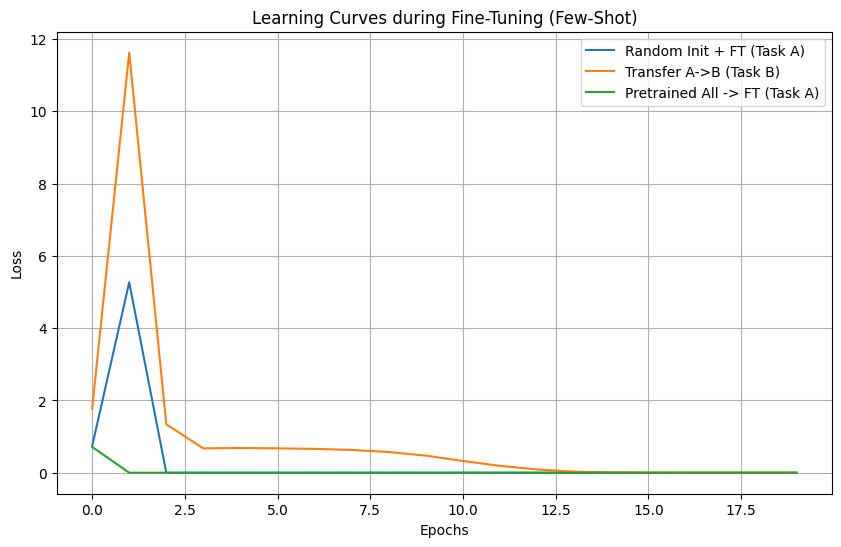

Method                         | Task       | Accuracy  
-------------------------------------------------------
Random Init + FT               | A (0 vs 1) | 92.00%
Transfer A -> B                | B (2 vs 3) | 40.00%
Pretrain All -> FT             | A (0 vs 1) | 83.50%


In [36]:
#Analysis and Plots
plt.figure(figsize=(10, 6))
plt.plot(loss_random_ft, label='Random Init + FT (Task A)')
plt.plot(loss_transfer, label='Transfer A->B (Task B)')
plt.plot(loss_pretrain_ft, label='Pretrained All -> FT (Task A)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves during Fine-Tuning (Few-Shot)')
plt.legend()
plt.grid(True)
plt.show()
print(f"{'Method':<30} | {'Task':<10} | {'Accuracy':<10}")
print("-" * 55)
print(f"{'Random Init + FT':<30} | {'A (0 vs 1)':<10} | {acc_random_ft:.2f}%")
print(f"{'Transfer A -> B':<30} | {'B (2 vs 3)':<10} | {acc_transfer:.2f}%")
print(f"{'Pretrain All -> FT':<30} | {'A (0 vs 1)':<10} | {acc_pretrain_ft:.2f}%")

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1 -> Pre-training on all 10 digits.<br>
The model trained on all 10 digits has seen the widest variety of curves, loops, and edges. It has learned a very robust feature extractor that generalizes well. When we fine-tune on the support set, we are essentially just teaching the final layer "which of these robust features correspond to 0 and which to 1".
<br><br>
2 -> Even though the model saw Task B (digits 2 and 3) during pre-training, it learned them as part of a 10-way classification problem (Output probabilities over [0..9]). When we fine-tune for the binary task:

Head Replacement: We cut off the 10-neuron output and replace it with a 2-neuron output.

Realignment: The fine-tuning process aligns the existing internal features of "2" and "3" to these two new neurons.
<br><br>
3 -> It will work better than random, but worse than digit-to-digit transfer.<br><br>Freeze early layers: Keep the edge detectors (first conv layer).

Unfreeze later layers: Allow the later layers (that detect complex shapes) to change significantly during fine-tuning.

Lower Learning Rate: To avoid destroying the useful low-level weights.<br><br>
4 -> We have used Transfer Learning. MAML explicitly optimizes the initialization for adaptability, whereas standard pre-training optimizes for performance on the pre-training task.

# ALL THE BEST !